In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein
import time
import torchaudio

from morse.models import CNNResidualBlock, TransformerResidualBlock, PoolingTransition, CNNTransformer, CTCHead
from morse.models import MySomething, SimpleCNN
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
from morse.augmentations import rotation_transform
from morse.text_helpers import Vectorizer, encode_to_morse, decode_from_morse

from morse.generators import MorseGenerator

In [2]:
labels_dir = '../'
data_dir = '../data/melspec_nfft512_nc64'

full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ

In [3]:
index_to_letter = sorted(set(''.join(full_train_df['message'])))
pad_value = 0
print(index_to_letter)
letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
dictionary_size = len(index_to_letter)
print(dictionary_size)
print(letter_to_index)

vectorizer = Vectorizer(letter_to_index, index_to_letter)
print(vectorizer.text_transform('ПРИВЕТ #'))

[' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
44
{' ': 0, '#': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'А': 12, 'Б': 13, 'В': 14, 'Г': 15, 'Д': 16, 'Е': 17, 'Ж': 18, 'З': 19, 'И': 20, 'Й': 21, 'К': 22, 'Л': 23, 'М': 24, 'Н': 25, 'О': 26, 'П': 27, 'Р': 28, 'С': 29, 'Т': 30, 'У': 31, 'Ф': 32, 'Х': 33, 'Ц': 34, 'Ч': 35, 'Ш': 36, 'Щ': 37, 'Ъ': 38, 'Ы': 39, 'Ь': 40, 'Э': 41, 'Ю': 42, 'Я': 43}
tensor([27, 28, 20, 14, 17, 30,  0,  1])


In [4]:
device = 'cpu'

In [6]:
n_epochs = 30
batch_size = 128

lr = 1e-3
step_gamma = 1
dropout = 0.165

n_pools = 4
n_blocks_before_pool = 3
pooling_overlap = True

group = 'FreshStart'
run_name = 'const_lr'

config = {
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    
    'lr': lr,
    'step_gamma': step_gamma,
    'dropout': dropout,

    'n_pools': n_pools,
    'n_blocks_before_pool': n_blocks_before_pool,
    'pooling_overlap': pooling_overlap,
}


model = SimpleCNN(d_input=64, d_model=64, d_inner=64, d_output=dictionary_size + 1, 
                  n_pools=n_pools, n_blocks_before_pool=n_blocks_before_pool, pooling_overlap=pooling_overlap,
                  dropout=dropout).to(device)
model.load_state_dict(torch.load('../models/synth/simple_cnn_with_noise_aug.pt', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
def batch_text_transform(texts):
    vecs, lengths = vectorizer.batch_text_transform(texts, pad_value=pad_value)
    return vecs + 1, lengths

In [8]:
from sklearn.model_selection import train_test_split

train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
print(train_index.shape, val_index.shape)
val_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(full_train_df.iloc[val_index]['id'])))))
val_labels = list(full_train_df.iloc[val_index]['message'])
valset = ListDataset(val_features, val_labels)
print(len(valset))

(25000,) (5000,)


5000it [00:44, 111.49it/s]

5000


In [9]:
generator = (valset[i] for i in range(250))

val_ctc_probs = []
val_ctc_labels = []

model.eval()
with torch.no_grad():
    for features, labels in tqdm(generator):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        val_ctc_probs.append(probs)
        val_ctc_labels.append(labels)

print(len(val_ctc_probs))

250it [00:01, 192.98it/s]

250


In [10]:
distance_buffer = []
for prob, label in zip(tqdm(val_ctc_probs), val_ctc_labels):
    seqs, likelihood = LongCTCSampler.sample(prob, beam_size=10)
    text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
    # print(text, label)
    decoded_message = text
    dist = Levenshtein.distance(decoded_message, label)
    # print(dist)
    distance_buffer.append(dist)
val_mean_dist = np.mean(distance_buffer)
print(val_mean_dist)

  0%|          | 0/250 [00:00<?, ?it/s]e:\dev\ML\morse\src\morse\samplers.py:53: RuntimeWarning: divide by zero encountered in log
  probs = np.log(probs)
100%|██████████| 250/250 [00:06<00:00, 38.50it/s]

9.272


# inference

In [11]:
test_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(test_df['id'][-100:])))))
# val_labels = list(full_train_df.iloc[val_index]['message'])
# valset = ListDataset(val_features, val_labels)
print(len(test_features))

100it [00:00, 141.82it/s]

100


In [12]:
test_ctc_probs = []
# val_ctc_labels = []

model.eval()
with torch.no_grad():
    for features in tqdm(test_features):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        test_ctc_probs.append(probs)
        # val_ctc_labels.append(labels)

print(len(test_ctc_probs))

100%|██████████| 100/100 [00:00<00:00, 166.90it/s]

100


In [13]:
test_decoded_list = []
for prob in tqdm(test_ctc_probs):
    seqs, likelihood = LongCTCSampler.sample(prob, beam_size=10)
    text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
    test_decoded_list.append(text)
print(len(test_decoded_list))

100%|██████████| 100/100 [00:07<00:00, 14.16it/s]

100


In [14]:
star_features = test_features[-17:]
star_pred_messages = test_decoded_list[-17:]
actual_morse = [''] * 17
print(len(star_features))
print(star_features[0].shape)

17
torch.Size([64, 3001])


In [15]:
def show_star_message(idx, start=0, end=1):
    message = star_pred_messages[idx]
    print(message)
    print(encode_to_morse(message))
    plt.figure(figsize=(18, 10), dpi=80)
    length = star_features[0].shape[1]
    # [:, :int(length * end)]
    start_pos = int(length * start)
    end_pos =int(length * end)
    plt.imshow(star_features[idx], aspect=5)
    plt.plot([start_pos, start_pos], [0, 64], color='red')
    plt.plot([end_pos, end_pos], [0, 64], color='aqua')
    plt.show()
    plt.figure(figsize=(18, 10), dpi=80)
    plt.imshow(star_features[idx][:, start_pos:end_pos], aspect=5)
    plt.show()

ДАМИНАМТ ДОТИ РСЫСАМЦИ
 ДАМ МТ ИОТЕ Н СЕЫ МЫА0ЪЯЪЙЪЦИ#
-.. .- -- / -- - / .. --- - . / -. / ... . -.-- / -- -.-- .- ----- .--.-. .-.- .--.-. .--- .--.-. -.-. .. --.--


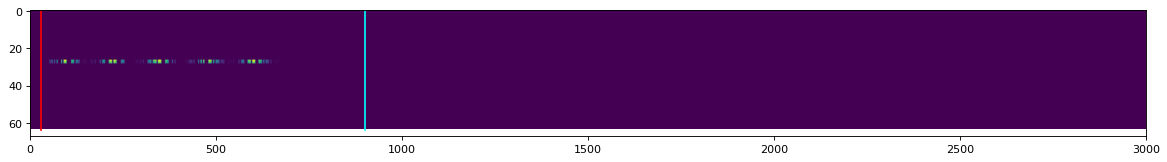

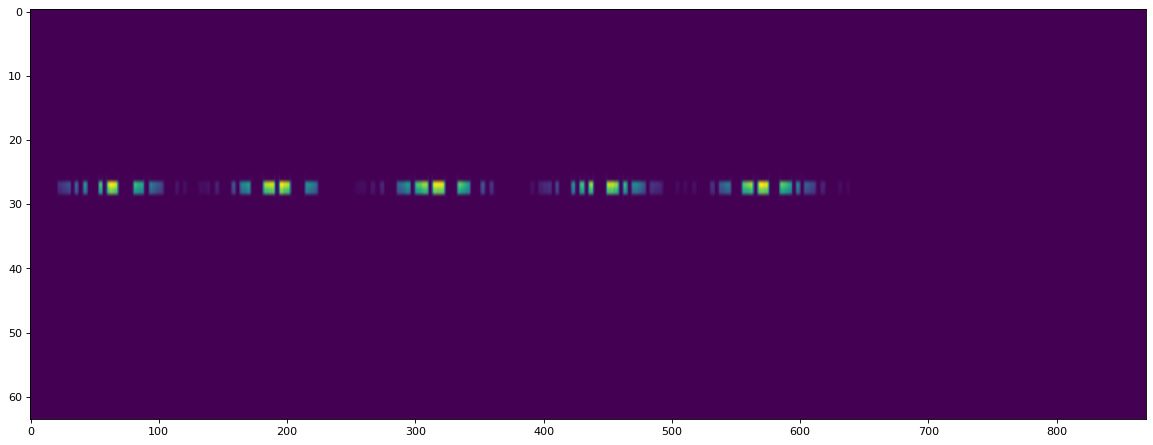

In [16]:
idx = 0
actual_morse[idx] = '-.. .- -- .. -. .- -- - / -.. --- - .. / .-. ... -.-- ... .- -- -.-. ..'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.01, end=0.3)

ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМЬТКТЧМЫН ДТЫМРГЗ ЕПИГ
И ИЛ ЬСВЕДТКЧЕВНТ ЯМДМЫМЮНЯМГ ЮТЫМ ЬТЧ МЫН НТЫМРГЗ ЕЧИГ ЭФД5У46БЬ5РЖ5Э5Э3МЩ5ГЦ6Л5Н5
.. / .. .-.. / -..- ... .-- . -.. - -.- ---. . .-- -. - / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- --. / ..-- - -.-- -- / -..- - ---. / -- -.-- -. / -. - -.-- -- .-. --. --.. / . ---. .. --. / ..-.. ..-. -.. ..... ..- ....- -.... -... -..- ..... .-. ...- ..... ..-.. ..... ..-.. ...-- -- --.- ..... --. -.-. -.... .-.. ..... -. .....


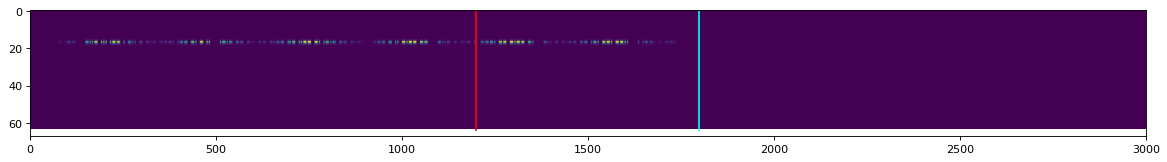

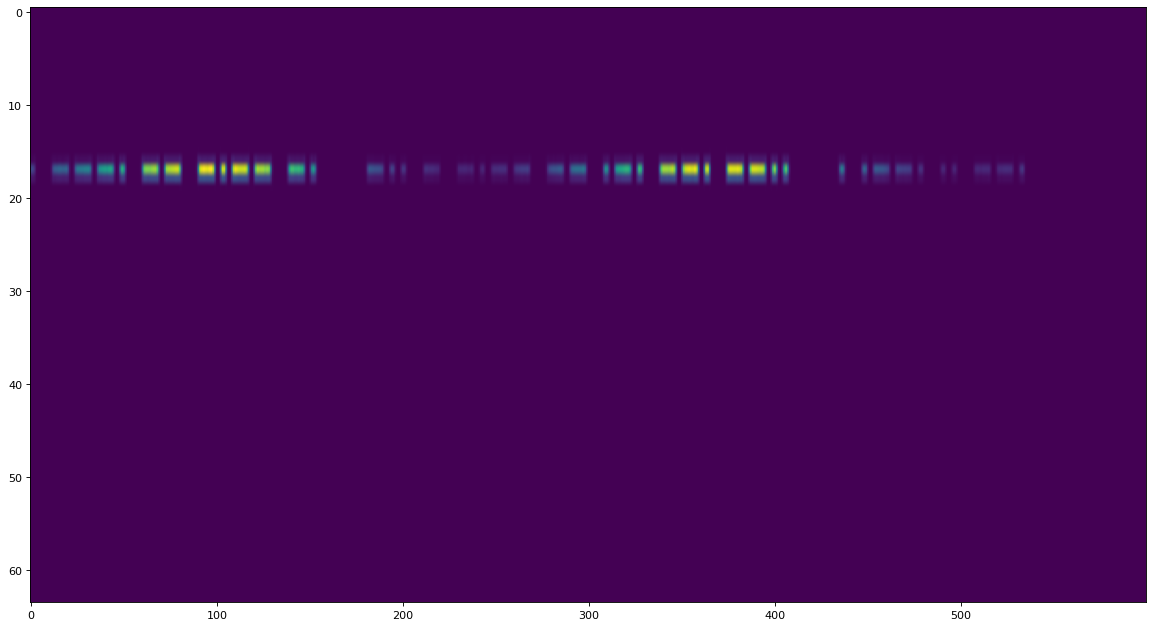

In [17]:
idx = 1
actual_morse[idx] = '.. .-.. / -..- ... .-- . -.. - -.- ---. .-- -. - .. / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-. / ..-- - .. -.-- -- -..- - -.- - ---. -- -.-- -. / -.. - -.-- -- .-. --. --.. / . .--. .. --.'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.4, end=0.6)

АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА
 А НХ МОТЕГТ Н ВКТДАМ НТШМ НИ МТНЮТА КЙ39
.- / -. .... / -- --- - . --. - / -. / .-- -.- - -.. .- -- / -. - ---- -- / -. .. / -- - -. ..-- - .- / -.- .--- ...-- ----.


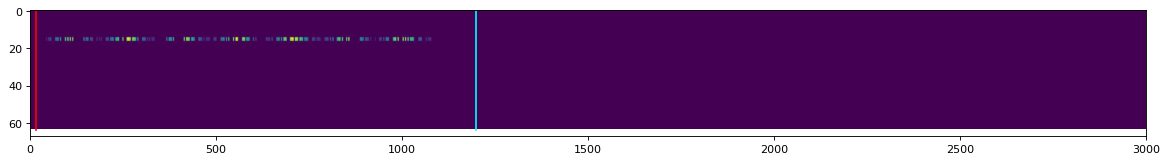

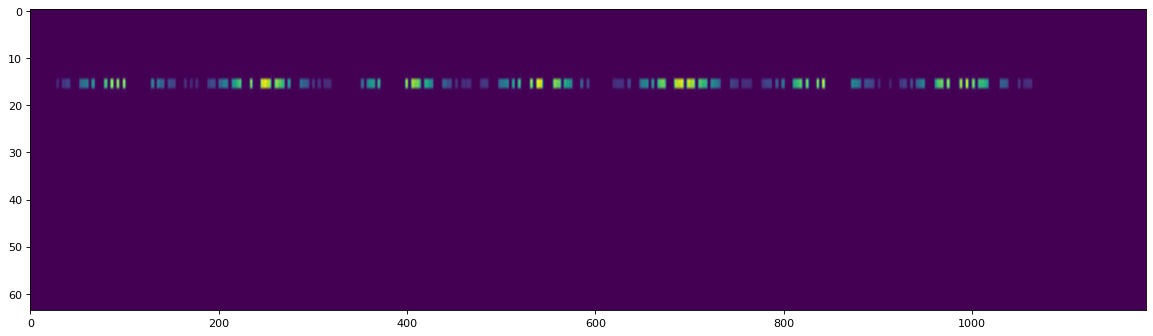

In [18]:
idx = 2
actual_morse[idx] = '.- -. .... / .-- ... --- . --. -..- / .-. / .-- -.- - -.. .- -- .. / -. -.- ---- -- -.. -. .. / --. . -.- -. ...- - .-'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.005, end=0.4)

ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНХНУСИ
 ЕЛ НЕАСДП ЬОЕМУНТА ЕГМТСОЕП ЬСХЫСУХ ХНУ ЮН ХНУИ 0Е
. .-.. / -. . .- ... -.. .--. / -..- --- . -- ..- -. - .- / . --. -- - ... --- . .--. / -..- ... .... -.-- ... ..- .... / .... -. ..- / ..-- -. / .... -. ..- .. / ----- .


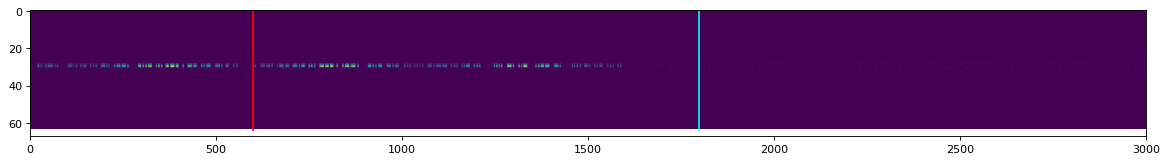

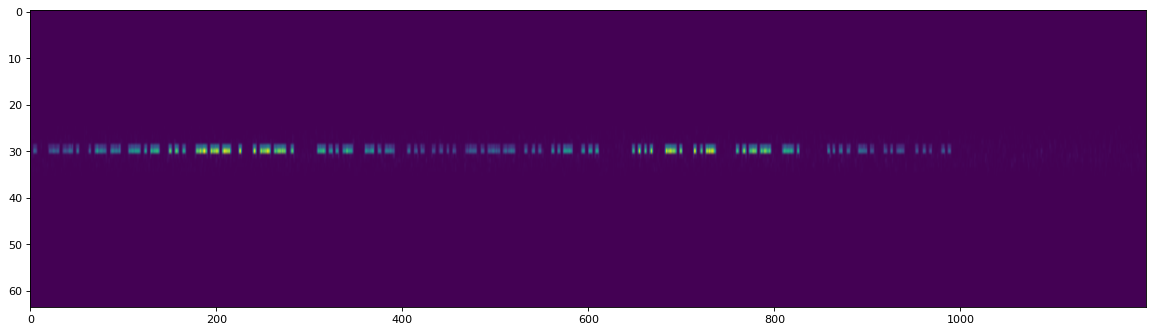

In [19]:
idx = 3
actual_morse[idx] = '.. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- -. - .. / .. --. .-- -.- ... --- . .--. / -..- -.- ... .... -.-- ... ..- ... / .... -. ..- / ..-- -. / .... -. .... -. ..- ... ..'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.2, end=0.6)

ЕТЬТКП ДСЯНКМЫОЦ ИМК
 ЕТЬТКП ДСАНКМЫОЦ ИММ Н13ЕЦТ#Ч1Ы Е#О
. - -..- - -.- .--. / -.. ... .- -. -.- -- -.-- --- -.-. / .. -- -- / -. .---- ...-- . -.-. - --.-- ---. .---- -.-- / . --.-- ---


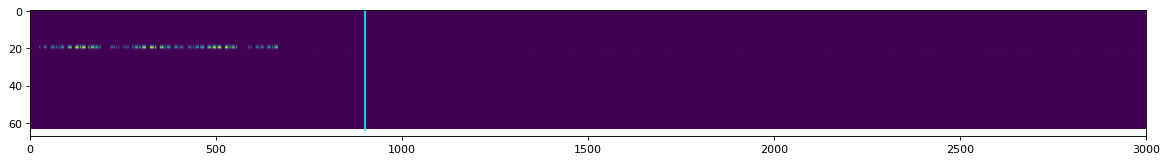

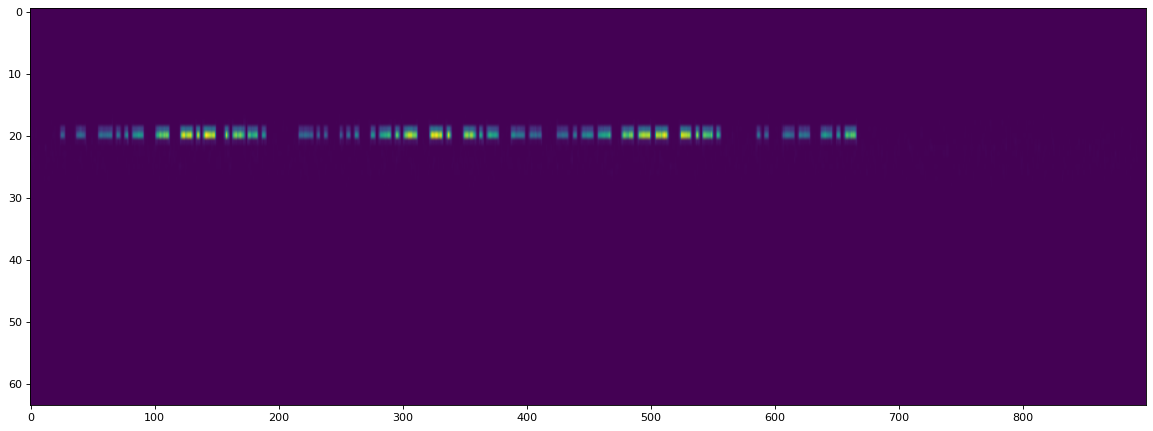

In [20]:
idx = 4
actual_morse[idx] = '. - -..- - -.- .--. / -.. ... .-.- -. -.- -- -.-- --- -.-. / .. -- -.-'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0, end=0.3)

КНОЬКМ СОЕНЫМОП ЬСЮНВМ
 ЫНОЬКМ СОЕНЫМОП ТЬСЕЮНММ ЕЙ0ВОРОМШШМШЫАЧЫА
-.-- -. --- -..- -.- -- / ... --- . -. -.-- -- --- .--. / - -..- ... . ..-- -. -- -- / . .--- ----- .-- --- .-. --- -- ---- ---- -- ---- -.-- .- ---. -.-- .-


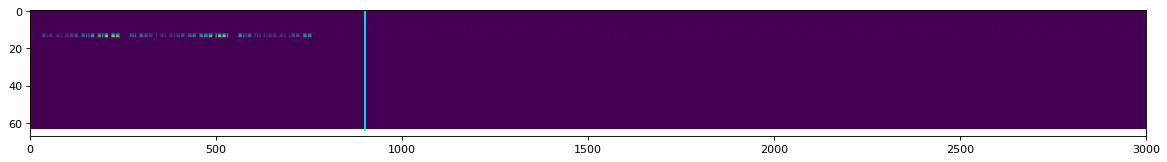

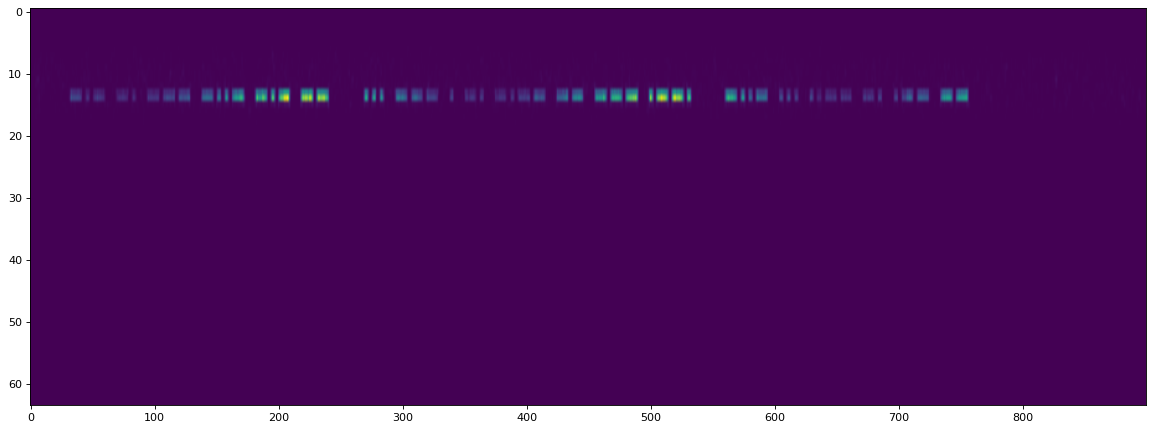

In [21]:
idx = 5
actual_morse[idx] = '-.- -. --- -..- -.- -- / ... --- . -. -.-- -- --- .--. / -..- ... ..-- -. .-- --'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0, end=0.3)

ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ НЛУСВ М ЧТЫНАМБ
 ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ НЛУСВ М ЧТЫНАМБ 9СЫЩ6РС5ЛГИ33С
.. .-.. / -..- ... --- . -. -.. -- -.-- -- / .--- -.-- -. ..- ... / .--- -.-- -- ---. .- - ..- ... / -..- -.- - -.. .-.. .... - / -.-- -- ...- .- .-.. ---- / -. .-.. ..- ... .-- / -- / ---. - -.-- -. .- -- -... / ----. ... -.-- --.- -.... .-. ... ..... .-.. --. .. ...-- ...-- ...


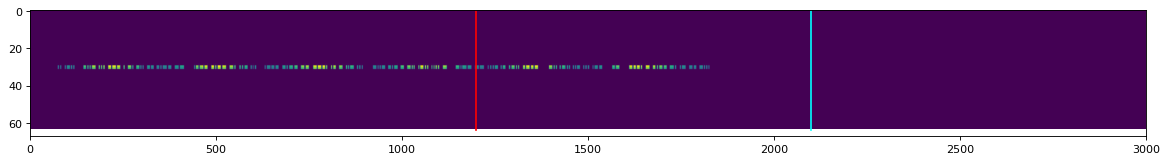

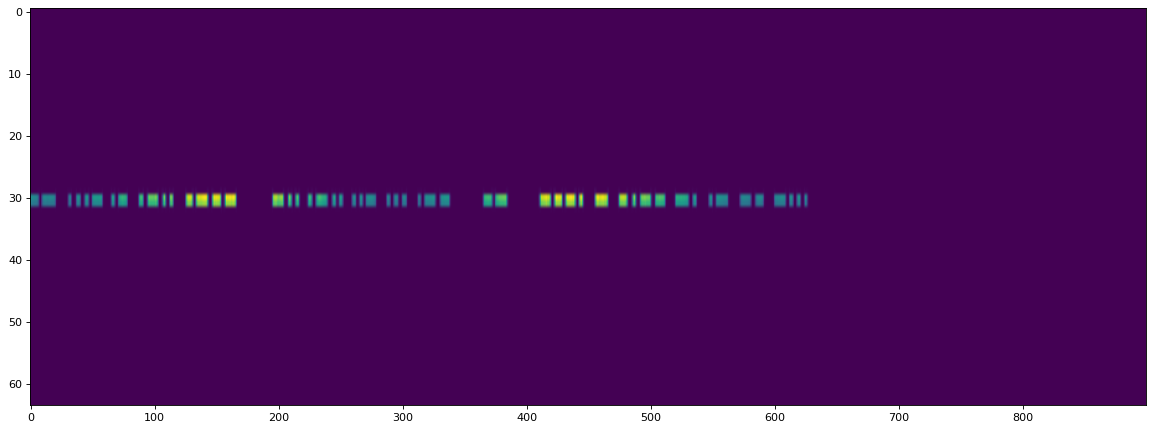

In [43]:
# got with model from this point onward

idx = 6
actual_morse[idx] = '.. .-.. / -..- ... --- . -. -.. -- -.-- -- / .--- -.-- -. ..- ... / .--- -.-- -- ---. .- - ..- ... / -..- -.- - -.. .-.. .... - / -.-- -- ...- .- .-.. ---- / -. .-.. ..- ... .-- / -- / ---. - -.-- -. .- -- -...'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.4
show_star_message(idx, start=start, end=start + window_width)

МЛ ДАСДП ОСЮВНЫМ НЮЙГРГ ЕТЫТУКНЩН
М ЕЛ ДАДП ОХЮВНЫМ НЮШГРГ ЕТЫТУКНЩН Н4УМЪЪХДТ6ЙШТМУЧЫ24ЬСИ С6ЛЪЧЕНЫЮ8
-- / . .-.. / -.. .- -.. .--. / --- .... ..-- .-- -. -.-- -- / -. ..-- ---- --. .-. --. / . - -.-- - ..- -.- -. --.- -. / -. ....- ..- -- .--.-. .--.-. .... -.. - -.... .--- ---- - -- ..- ---. -.-- ..--- ....- -..- ... .. / ... -.... .-.. .--.-. ---. . -. -.-- ..-- ---..


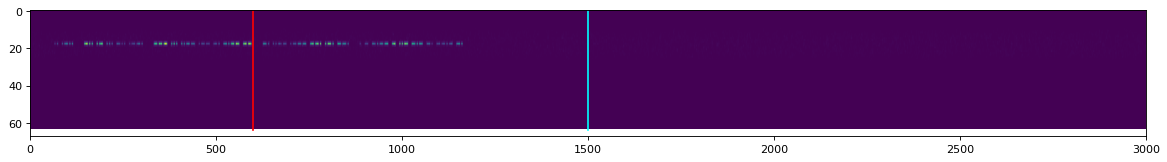

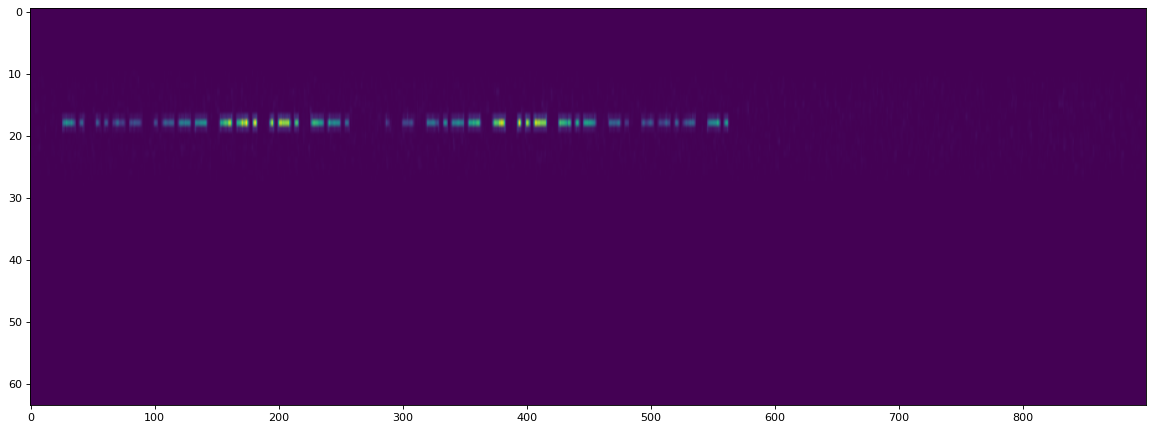

In [49]:
# got with model from this point onward

idx = 7
actual_morse[idx] = '-- .-.. / -.. .- ... -.. .--. / --- ... ..-- .-- -. -.-- -- / -. ..-- .--- --. .-. --. / . - -.-- - ..- -.- -. --.- -.'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.2
show_star_message(idx, start=start, end=start + window_width)

АС АТ ИСЧТИ ККЖНЕПОЦ ЮН НЙОСЫЗЕАГЗ ДТКАСОЕП ОМИДСЫСХ
 АС М Т ИТЧ ТЕ М МЮ ЕО Н 2 НВШМСТЕВ З МЕТМАО ЕЙ ШТ МИГЕ ЫЕ 
.- ... / -- / - / .. - ---. / - . / -- / -- ..-- / . --- / -. / ..--- / -. .-- ---- -- ... - . .-- / --.. / -- . - -- .- --- / . .--- / ---- - / -- .. --. . / -.-- .


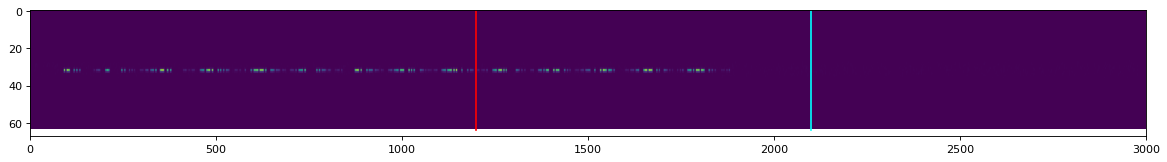

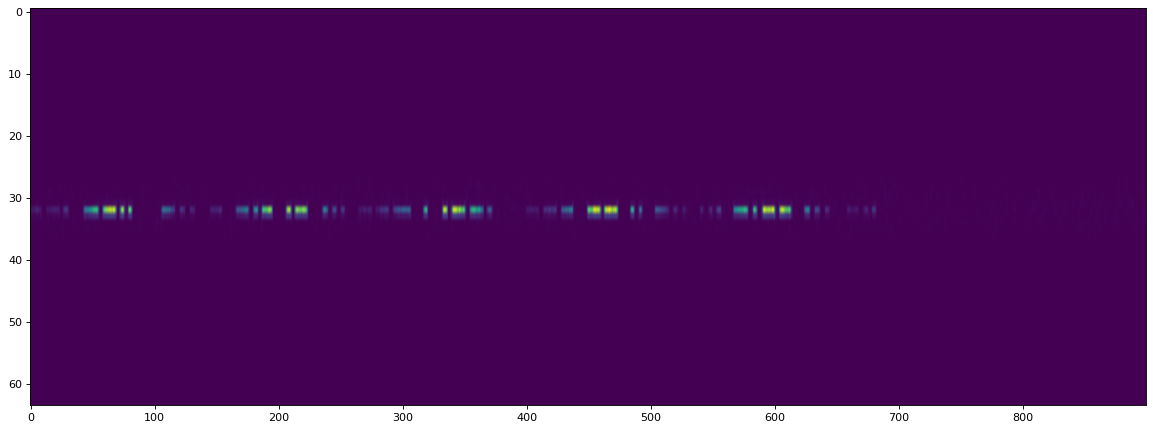

In [54]:
# got with model from this point onward

idx = 8
actual_morse[idx] = '.- ... / .- - / .. ... ---. - .. / -.- -.- ...- -. . .--. --- -.-. / ..-- -. /  -. .--- --- ... -.-- --.. . .- --. --.. / -.. - -.- .- ... --- . .--. / --- -- .. -.. ... -.-- ... ....'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.4
show_star_message(idx, start=start, end=start + window_width)

ТОЫМ ДЛ ОЫЛХМЕТ #ЕС ЬСОЫНСМТ ЕС СЕРЫНСМТ ЕС СЕРЫМРАМЕТОП
 Ш ЫМ ЕЧ Т ШЛЕ М Т М С ЫН ТЫМА Т Е ИЕ ЕЫМ ММЕМТМ П Ч#Ч
---- / -.-- -- / . ---. / - / ---- .-.. . / -- / - / -- / ... / -.-- -. / - -.-- -- .- / - / . / .. . / . -.-- -- / -- -- . -- - -- / .--. / ---. --.-- ---.


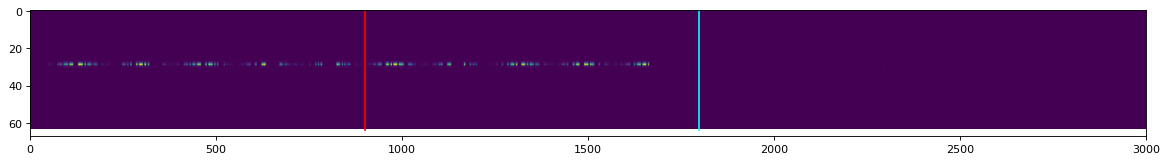

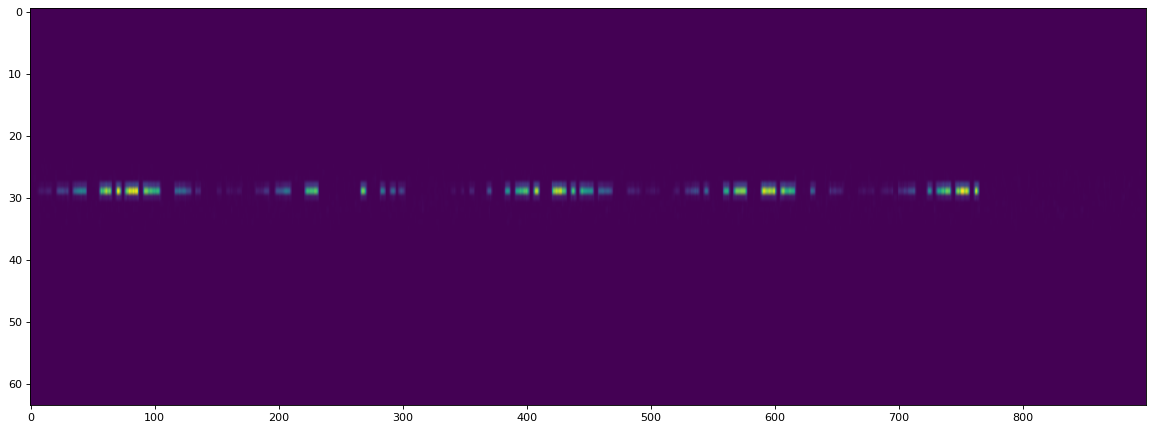

In [60]:
# got with model from this point onward

idx = 9
actual_morse[idx] = '- --- -.-- -- / -.. .-.. / --- -.-- .-.. .... -- . - / --.-- . ... / -..- ... --- -.-- -. ... -- - / . ... / ... . .-. -.-- -. ... -- - / . ... / ... . .-. -.-- -- .-. .- -- . - --- .--.'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.3
show_star_message(idx, start=start, end=start + window_width)

АН ЖНОЕСЕТ ЬТКТВНЖМ ГДТЫМЖТААСБ АН 75 РМЫСЯМРЫСД
Й Н У ОЕФЕТ ЬТТВ НЖМ ГТ#МСТААСД АН Т7Н5 НМ#СВМ РЫ ЕД ВЫ3ЪО Е1ЫФЧВ
.--- / -. / ..- / --- . ..-. . - / -..- - - .-- / -. ...- -- / --. - --.-- -- ... - .- .- ... -.. / .- -. / - --... -. ..... / -. -- --.-- ... .-- -- / .-. -.-- / . -.. / .-- -.-- ...-- .--.-. --- / . .---- -.-- ..-. ---. .--


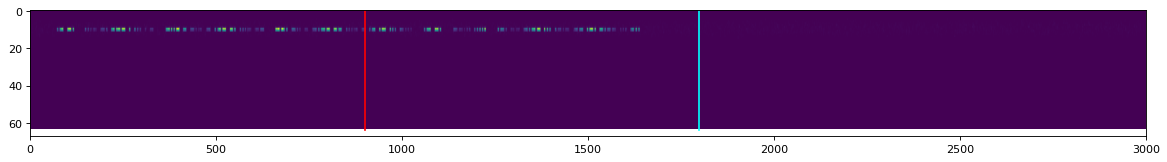

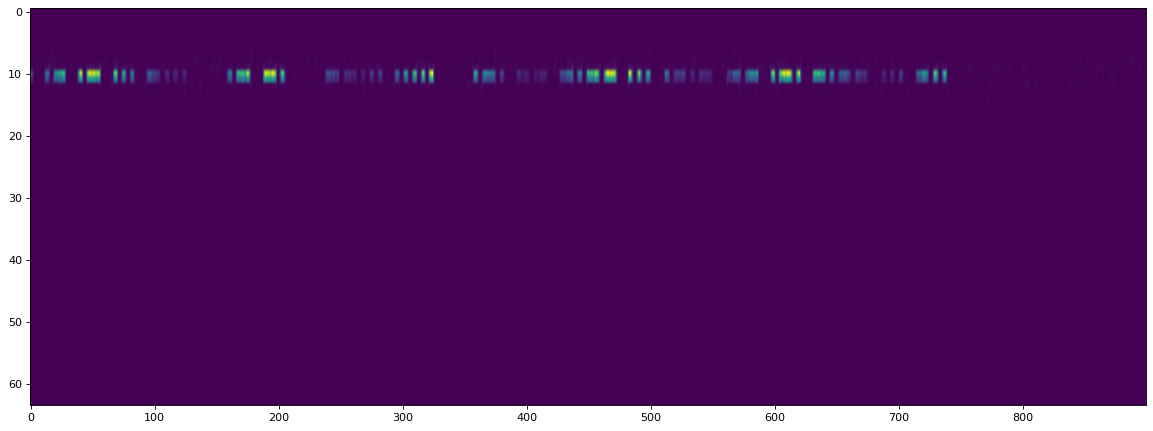

In [65]:
# got with model from this point onward

idx = 10
actual_morse[idx] = '.- -. / ...- -. --- . ... . - / -..- - -.- - .-- -. ...- -- / --. -.. - -.-- -- ...- - .- .- ... -... / .- -. / --... ..... / .-. -- -.-- ... .-.- -- .-. -.-- ... -..'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.3
show_star_message(idx, start=start, end=start + window_width)

ОДЦЮП ЬСВВТКЧМДНТЕОЦ ДКГЖАГЗ АТГЕСИМИЛИМ ЫНЫПЯНИМ АНХМШ СЬТКНЕСКСД
 ОДЮП ЬСВВТМЧ МДНТЕМЦ НМГЖАНЗ АТНГЕСИМИЛИМ ТЫНЫМПЯНИТМ АНХМШ СЬТКНЕСМСД Н30ЬЧ
--- -.. ..-- .--. / -..- ... .-- .-- - -- ---. / -- -.. -. - . -- -.-. / -. -- --. ...- .- -. --.. / .- - -. --. . ... .. -- .. .-.. .. -- / - -.-- -. -.-- -- .--. .-.- -. .. - -- / .- -. .... -- ---- / ... -..- - -.- -. . ... -- ... -.. / -. ...-- ----- -..- ---.


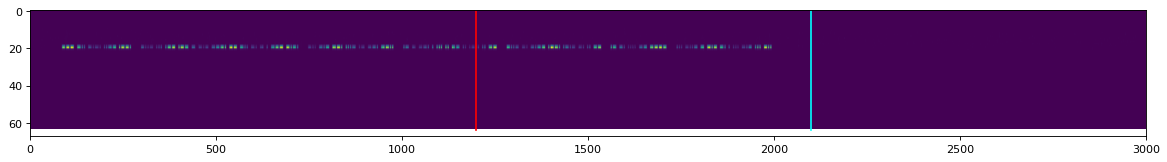

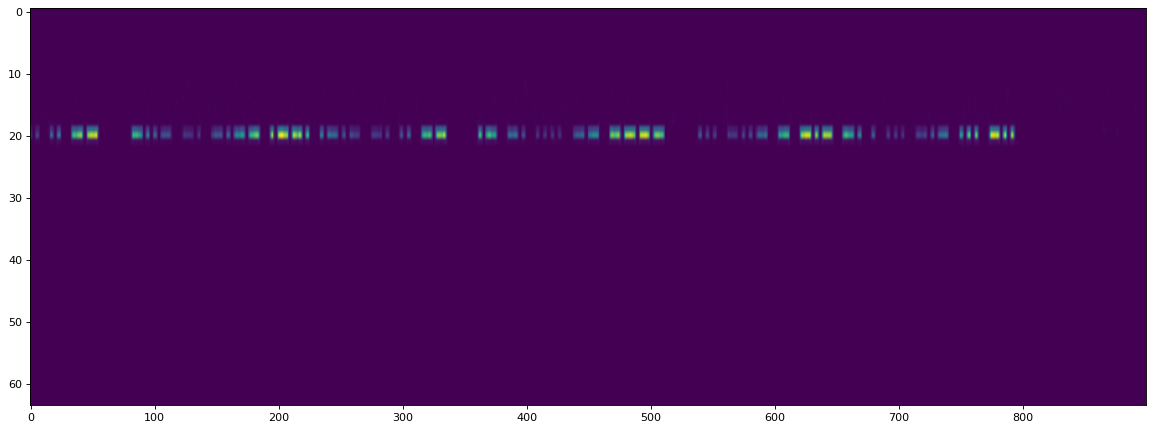

In [70]:
# got with model from this point onward

idx = 11
actual_morse[idx] = '--- -.. -.-. ..-- .--. / -..- ... .-- .-- - -.- ---. -- -.. -. - . --- -.-. / -.. -.- --. ...- .- --. --.. / .- - --. . ... .. -- .. .-.. .. -- / -.-- -. -.-- .--. .-.- -. .. -- / .- -. .... -- ---- / ... -..- - -.- -. . ... -.- ... -..'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.4
show_star_message(idx, start=start, end=start + window_width)

ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕТЫТБ
А ОРСКХ ИЛ ДАСДП ЬСОЕМУАТИ ЕБАЛ КНРТАЛШ ВДМУНЕТЫТБ Н1Ъ
.- / --- .-. ... -.- .... / .. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- .- - .. / . -... .- .-.. / -.- -. .-. - .- .-.. ---- / .-- -.. -- ..- -. . - -.-- - -... / -. .---- .--.-.


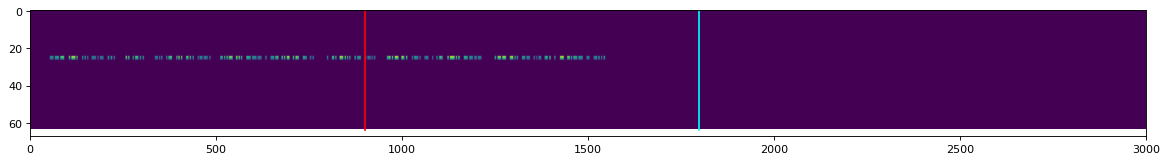

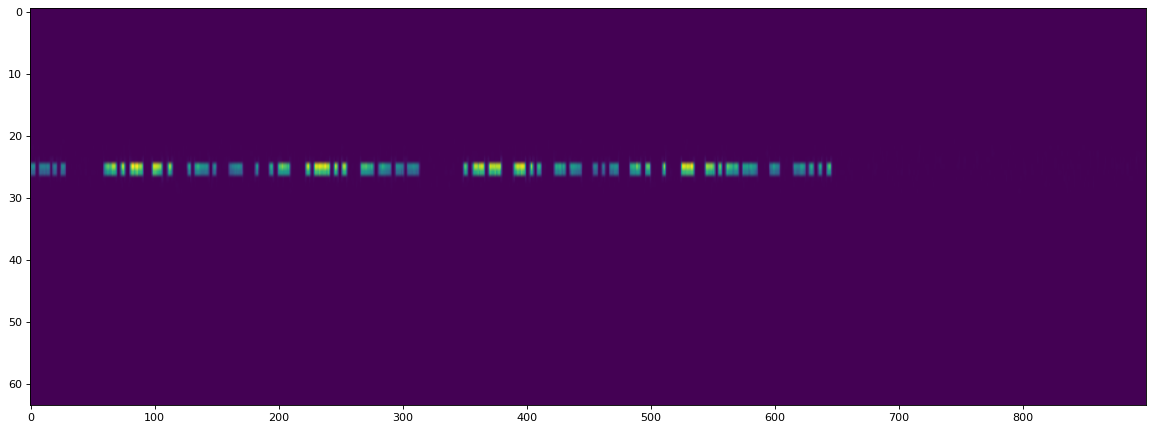

In [75]:
# got with model from this point onward

idx = 12
actual_morse[idx] = '--- .-. ... -.- ... / .. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- .- - .. / . -. -... .- .-.. / -.- -. .-. - . .- .-.. ---- / .-- -.. -- ..- -. . - -.-- - -...'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.3
show_star_message(idx, start=start, end=start + window_width)

ОИСЧТИ СЕЬКНДМЕП ЮН ДНИМ ОЬНОМЕТЫПАЛББ ЖТЫАСР
 ОИСЧТ СЕЬКНДНМЕП ЮН ДНИМ ОТ Н0МЕТЫВАЛБД  ТЫАСХР ИЗИКЦЙПЪЭЯЩ99Ф
--- .. ... ---. - / ... . -..- -.- -. -.. -. -- . .--. / ..-- -. / -.. -. .. -- / --- - / -. ----- -- . - -.-- .-- .- .-.. -... -.. / / - -.-- .- ... .... .-. / .. --.. .. -.- -.-. .--- .--. .--.-. ..-.. .-.- --.- ----. ----. ..-.


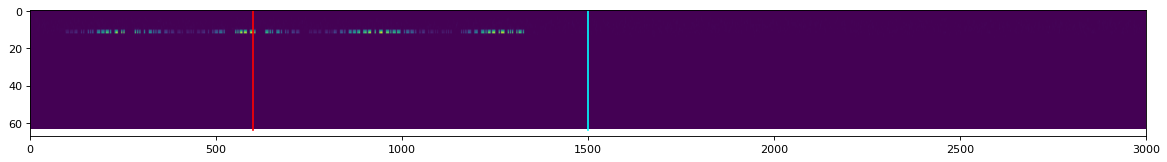

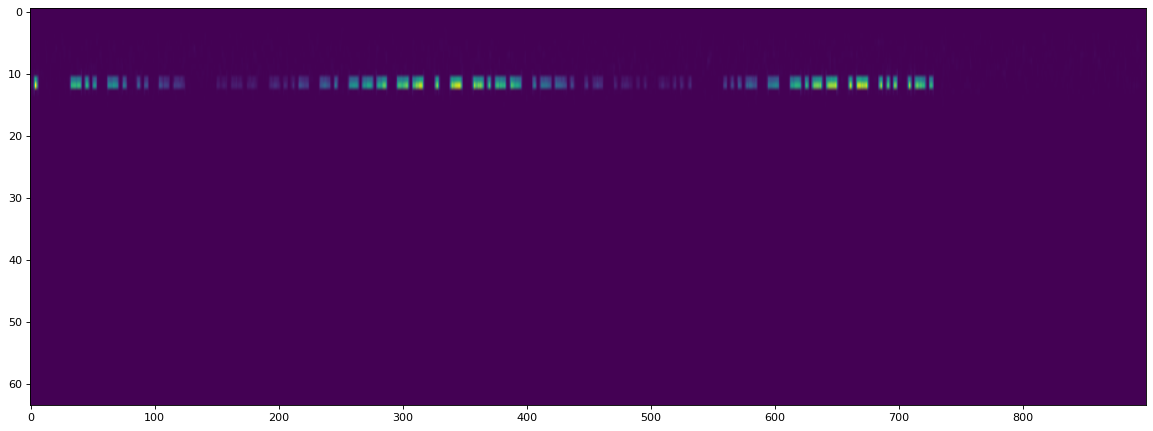

In [79]:
# got with model from this point onward

idx = 13
actual_morse[idx] = '--- .. ... ---. - .. / ... . -..- -.- -. -.. -- . .--. / ..-- -. / -.. -. .. -- / --- -..- -. --- -- . - -.-- .--. .- .-.. -... -... / ...- - -.-- .- ... .-.'
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.2
show_star_message(idx, start=start, end=start + window_width)


0 ТОШ М НЛ ЫИШЕТ0Ш ТЕТ ТМАГЕ9ОЦН ОИЕТБЕ НН ЦЛЫВ
----- / - --- ---- / -- / -. .-.. / -.-- .. ---- . - ----- ---- / - . - / - -- .- --. . ----. --- -.-. -. / --- .. . - -... . / -. -. / -.-. .-.. -.-- .--


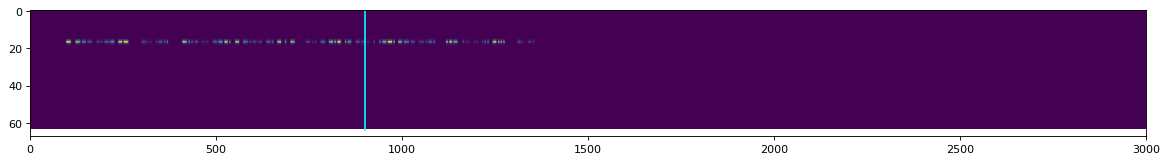

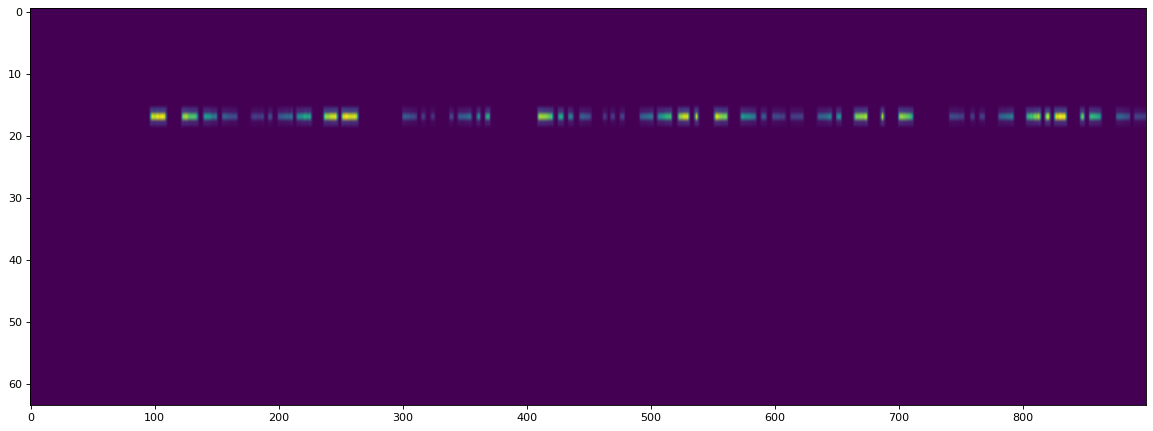

In [81]:
# got with model from this point onward

idx = 14
actual_morse[idx] = ''
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.0
show_star_message(idx, start=start, end=start + window_width)

In [ ]:
# got with model from this point onward

idx = 14
actual_morse[idx] = ''
print(decode_from_morse(actual_morse[idx]))
window_width = 0.3
start = 0.4
show_star_message(idx, start=start, end=start + window_width)

In [23]:
text = ' '.join([decode_from_morse(morse) for morse in actual_morse])
text

'ДАМИНАМТ ДОТИ РСЫСАМЦИ ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМЬТКТЧМЫН ДТЫМРГЗ ЕПИГ АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНХНУСИ ЕТЬТКП ДСЯНКМЫОЦ ИМК КНОЬКМ СОЕНЫМОП ЬСЮНВМ           '

In [38]:
# decoded_list = []
# model.eval()
# for features in tqdm(test_features):
#     with torch.no_grad():
#         outs = model(features[None].to(device))
#         probs = F.softmax(outs.squeeze(), dim=0).to('cpu')
#     seqs, likelihood = LongCTCSampler.sample(probs, beam_size=10)
#     text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
#     decoded_list.append(text)

In [33]:
reference_text = '''Единство предмета речи — это тема высказывания. Тема — это смысловое ядро текста, конденсированное и обобщённое содержание текста.

Понятие «содержание высказывания» связано с категорией информативности речи и присуще только тексту. Оно сообщает читателю индивидуально-авторское понимание отношений между явлениями, их значимости во всех сферах придают ему смысловую цельность.

В большом тексте ведущая тема распадается на ряд составляющих подтем; подтемы членятся на более дробные, на абзацы (микротемы).

Завершённость высказывания связана со смысловой цельностью текста. Показателем законченности текста является возможность подобрать к нему заголовок, отражающий его содержание.

Таким образом, из смысловой цельности текста вытекают следующие признаки текста
Исключительно лингвистические элементы, обеспечивающие когерентность текста, в своей совокупности обозначаются термином «когезия текста» — его связность. Однако эти лингвистические средства не обязательно позволяют достичь когерентности текста. Они не всегда способствуют осмысленности дискурса. Текст является целостным — когерентным — только в том случае, если в нём целостно использованы фоновые знания. Когезия обеспечивает внутреннюю лексико-грамматическую связанность текста, при которой интерпретация одних элементов текста зависит от других, что позволяет адресанту реализовать свою коммуникативную цель с наибольшей точностью и ясностью. Когерентность организует части дискурса так, что авторский замысел становится понятен адресату, реализует уместность дискурса. Когерентность означает понятийно-смысловую целостность текста, когезия — использование
ранних этапах становления лингвистической теории текста имелась тенденция понимать когезию как средство формальной внутритекстовой связи. В процессе развития лингвистики текста когезию стали понимать значительно шире. Принимаются во внимание и её текстообразующие потенции в области формирования не только структурной, но и смысловой (содержательной) целостности речевого произведения. Ряд исследователей считает, что когезия, средства которой определяются когерентностью, то есть глобальной связностью текста, шире когерентности, так как она охватывает как формально-грамматические аспекты связи высказываний, так и семантико-прагматические, функциональные аспекты смысловой и деятельной связности дискурса, которые обеспечивают линейность информации. Как когезия, так и когерентность обеспечивают целостность и единство дискурса. Вместе средства когезии и когерентности, включающие логические, грамматические, лексические, стилистические, образные и другие средства, создают связный и понятный текст, реализующий определённый коммуникативный замысел. Когезия и когерентность представляют собой разные аспекты связности текста и могут рассматриваться как разные уровни функционирования одного и того
Логики и философы обнаружили необходимость введения понятия пресуппозиции при анализе высказываний ещё в XIX веке. Немецкий логик Г. Фреге одним из первых предложил различать утверждаемое и предполагаемое в некотором высказывании. Например, в предложении «Моцарт умер в нищете» предполагается, что имя «Моцарт» означает некоторый денотат, что жил человек с таким именем. По Фреге, это предположение не является частью высказывания, а лишь влияет на его истинностное значение. Если же имени референта не существует, высказывание не теряет смысла, но лишается истинностного значения
'''.replace('\n', '').replace('\r', '').replace('-', '').replace('—', '').replace('.', '').replace(',', '').lower()
reference_text

'единство предмета речи  это тема высказывания тема  это смысловое ядро текста конденсированное и обобщённое содержание текстапонятие «содержание высказывания» связано с категорией информативности речи и присуще только тексту оно сообщает читателю индивидуальноавторское понимание отношений между явлениями их значимости во всех сферах придают ему смысловую цельностьв большом тексте ведущая тема распадается на ряд составляющих подтем; подтемы членятся на более дробные на абзацы (микротемы)завершённость высказывания связана со смысловой цельностью текста показателем законченности текста является возможность подобрать к нему заголовок отражающий его содержаниетаким образом из смысловой цельности текста вытекают следующие признаки текстаисключительно лингвистические элементы обеспечивающие когерентность текста в своей совокупности обозначаются термином «когезия текста»  его связность однако эти лингвистические средства не обязательно позволяют достичь когерентности текста они не всегда спос

In [34]:
from collections import Counter
import itertools

def count_char_frequencies(text):
    """
    Count character frequencies in a string (case sensitive).
    Returns a Counter object with character frequencies.
    """
    return Counter(text)

def replace_chars(text, char_map):
    """
    Replace characters in a string using a 1-to-1 mapping.
    char_map: dictionary with {old_char: new_char} mappings
    Returns the transformed string.
    """
    return ''.join(char_map.get(c, c) for c in text)

def generate_frequency_mappings(source_freq, target_freq, n=10):
    """
    Generate possible mappings from most frequent chars in source to target.
    source_freq: Counter of character frequencies in source text
    target_freq: Counter of character frequencies in target language/expected distribution
    n: number of top characters to consider for permutations
    Returns a generator of possible mappings (dictionaries)
    """
    # Get top n characters from each (sorted by frequency)
    source_chars = [char for char, _ in source_freq.most_common(n)]
    target_chars = [char for char, _ in target_freq.most_common(n)]
    
    # Generate all possible permutations of mappings
    for perm in itertools.permutations(target_chars):
        yield dict(zip(source_chars, perm))

def frequency_analysis(ciphertext, reference_freq, n=10, top_mappings=5):
    """
    Perform frequency analysis on ciphertext using reference frequency distribution.
    ciphertext: the encrypted text
    reference_freq: Counter with expected character frequencies (e.g., English letters)
    n: number of top characters to consider
    top_mappings: number of top mappings to return
    Returns a list of (mapping, decrypted_text, score) tuples sorted by best score
    """
    cipher_freq = count_char_frequencies(ciphertext)
    results = []
    
    # Try different mappings and score them
    for mapping in generate_frequency_mappings(cipher_freq, reference_freq, n):
        decrypted = replace_chars(ciphertext, mapping)
        
        # Simple scoring: count how many of the top n chars match reference
        decrypted_freq = count_char_frequencies(decrypted)
        decrypted_top = [char for char, _ in decrypted_freq.most_common(n)]
        reference_top = [char for char, _ in reference_freq.most_common(n)]
        
        score = sum(1 for char in decrypted_top if char in reference_top)
        results.append((mapping, decrypted, score))
    
    # Return the top scoring mappings
    return sorted(results, key=lambda x: x[2], reverse=True)[:top_mappings]

# Example usage:
if __name__ == "__main__":
    # Example reference frequency (English letters)
    english_freq = Counter({
        'e': 12.7, 't': 9.1, 'a': 8.2, 'o': 7.5, 'i': 6.9,
        'n': 6.7, 's': 6.3, 'h': 6.1, 'r': 6.0, 'd': 4.3,
        'l': 4.0, 'c': 2.8, 'u': 2.8, 'm': 2.4, 'w': 2.4,
        'f': 2.2, 'g': 2.0, 'y': 2.0, 'p': 1.9, 'b': 1.5,
        'v': 0.98, 'k': 0.77, 'j': 0.15, 'x': 0.15, 'q': 0.095,
        'z': 0.074
    })
    
    
    # Example ciphertext (simple substitution cipher)
    ciphertext = "ifmmp xpsme"
    
    # Perform frequency analysis
    results = frequency_analysis(ciphertext, english_freq, n=5)
    
    print("Top possible decryptions:")
    for i, (mapping, decrypted, score) in enumerate(results, 1):
        print(f"\nOption {i} (score: {score}):")
        print(f"Mapping: {mapping}")
        print(f"Decrypted text: {decrypted}")

Top possible decryptions:

Option 1 (score: 5):
Mapping: {'m': 'e', 'p': 't', 'i': 'a', 'f': 'o', ' ': 'i'}
Decrypted text: aoeetixtsee

Option 2 (score: 5):
Mapping: {'m': 'e', 'p': 't', 'i': 'a', 'f': 'i', ' ': 'o'}
Decrypted text: aieetoxtsee

Option 3 (score: 5):
Mapping: {'m': 'e', 'p': 't', 'i': 'o', 'f': 'a', ' ': 'i'}
Decrypted text: oaeetixtsee

Option 4 (score: 5):
Mapping: {'m': 'e', 'p': 't', 'i': 'o', 'f': 'i', ' ': 'a'}
Decrypted text: oieetaxtsee

Option 5 (score: 5):
Mapping: {'m': 'e', 'p': 't', 'i': 'i', 'f': 'a', ' ': 'o'}
Decrypted text: iaeetoxtsee


In [35]:
ref_freq = Counter(reference_text)
    
    
# Example ciphertext (simple substitution cipher)
ciphertext = text

# Perform frequency analysis
results = frequency_analysis(ciphertext, ref_freq, n=5)

print("Top possible decryptions:")
for i, (mapping, decrypted, score) in enumerate(results, 1):
    print(f"\nOption {i} (score: {score}):")
    print(f"Mapping: {mapping}")
    print(f"Decrypted text: {decrypted}")

Top possible decryptions:

Option 1 (score: 5):
Mapping: {' ': ' ', 'М': 'е', 'Н': 'о', 'И': 'т', 'С': 'и'}
Decrypted text: ДАетоАеТ ДОТт РиЫиАеЦт тЛ ЬиВЕДТКЧВоТт ЯеДеЫеЮоЯеЦ ЮТтЫеЬТКТЧеЫо ДТЫеРГЗ ЕПтГ АоХ ВиОЕГЬ Р ВКТДАет оКШеДот ГЕКоЖТА тЛ ДАиДП ЬиОЕеУоТт тГВКиОЕП ЬКиХЫиУи ХоУ Юо ХоХоУит ЕТЬТКП ДиЯоКеЫОЦ теК КоОЬКе иОЕоЫеОП ЬиЮоВе           

Option 2 (score: 5):
Mapping: {' ': ' ', 'М': 'е', 'Н': 'о', 'И': 'и', 'С': 'т'}
Decrypted text: ДАеиоАеТ ДОТи РтЫтАеЦи иЛ ЬтВЕДТКЧВоТи ЯеДеЫеЮоЯеЦ ЮТиЫеЬТКТЧеЫо ДТЫеРГЗ ЕПиГ АоХ ВтОЕГЬ Р ВКТДАеи оКШеДои ГЕКоЖТА иЛ ДАтДП ЬтОЕеУоТи иГВКтОЕП ЬКтХЫтУт ХоУ Юо ХоХоУти ЕТЬТКП ДтЯоКеЫОЦ иеК КоОЬКе тОЕоЫеОП ЬтЮоВе           

Option 3 (score: 5):
Mapping: {' ': ' ', 'М': 'е', 'Н': 'т', 'И': 'о', 'С': 'и'}
Decrypted text: ДАеотАеТ ДОТо РиЫиАеЦо оЛ ЬиВЕДТКЧВтТо ЯеДеЫеЮтЯеЦ ЮТоЫеЬТКТЧеЫт ДТЫеРГЗ ЕПоГ АтХ ВиОЕГЬ Р ВКТДАео тКШеДто ГЕКтЖТА оЛ ДАиДП ЬиОЕеУтТо оГВКиОЕП ЬКиХЫиУи ХтУ Ют ХтХтУио ЕТЬТКП ДиЯтКеЫОЦ оеК КтОЬКе иОЕтЫеОП ЬиЮтВе           

Option 4 (sco

In [39]:
cipher_freq = count_char_frequencies(ciphertext)
reference_freq = ref_freq
results = []

# Try different mappings and score them
for mapping in generate_frequency_mappings(cipher_freq, reference_freq, 3):
    decrypted = replace_chars(ciphertext, mapping)
    print(decrypted)
    # # Simple scoring: count how many of the top n chars match reference
    # decrypted_freq = count_char_frequencies(decrypted)
    # decrypted_top = [char for char, _ in decrypted_freq.most_common(n)]
    # reference_top = [char for char, _ in reference_freq.most_common(n)]
    
    # score = sum(1 for char in decrypted_top if char in reference_top)
    # results.append((mapping, decrypted, score))

ДАеИоАеТ ДОТИ РСЫСАеЦИ ИЛ ЬСВЕДТКЧВоТИ ЯеДеЫеЮоЯеЦ ЮТИЫеЬТКТЧеЫо ДТЫеРГЗ ЕПИГ АоХ ВСОЕГЬ Р ВКТДАеИ оКШеДоИ ГЕКоЖТА ИЛ ДАСДП ЬСОЕеУоТИ ИГВКСОЕП ЬКСХЫСУС ХоУ Юо ХоХоУСИ ЕТЬТКП ДСЯоКеЫОЦ ИеК КоОЬКе СОЕоЫеОП ЬСЮоВе           
ДАоИеАоТ ДОТИ РСЫСАоЦИ ИЛ ЬСВЕДТКЧВеТИ ЯоДоЫоЮеЯоЦ ЮТИЫоЬТКТЧоЫе ДТЫоРГЗ ЕПИГ АеХ ВСОЕГЬ Р ВКТДАоИ еКШоДеИ ГЕКеЖТА ИЛ ДАСДП ЬСОЕоУеТИ ИГВКСОЕП ЬКСХЫСУС ХеУ Юе ХеХеУСИ ЕТЬТКП ДСЯеКоЫОЦ ИоК КеОЬКо СОЕеЫоОП ЬСЮеВо           
ДА ИоА ТеДОТИеРСЫСА ЦИеИЛеЬСВЕДТКЧВоТИеЯ Д Ы ЮоЯ ЦеЮТИЫ ЬТКТЧ ЫоеДТЫ РГЗеЕПИГеАоХеВСОЕГЬеРеВКТДА ИеоКШ ДоИеГЕКоЖТАеИЛеДАСДПеЬСОЕ УоТИеИГВКСОЕПеЬКСХЫСУСеХоУеЮоеХоХоУСИеЕТЬТКПеДСЯоК ЫОЦеИ КеКоОЬК еСОЕоЫ ОПеЬСЮоВ еееееееееее
ДАоИ АоТеДОТИеРСЫСАоЦИеИЛеЬСВЕДТКЧВ ТИеЯоДоЫоЮ ЯоЦеЮТИЫоЬТКТЧоЫ еДТЫоРГЗеЕПИГеА ХеВСОЕГЬеРеВКТДАоИе КШоД ИеГЕК ЖТАеИЛеДАСДПеЬСОЕоУ ТИеИГВКСОЕПеЬКСХЫСУСеХ УеЮ еХ Х УСИеЕТЬТКПеДСЯ КоЫОЦеИоКеК ОЬКоеСОЕ ЫоОПеЬСЮ Воеееееееееее
ДА ИеА ТоДОТИоРСЫСА ЦИоИЛоЬСВЕДТКЧВеТИоЯ Д Ы ЮеЯ ЦоЮТИЫ ЬТКТЧ ЫеоДТЫ РГЗоЕПИГоАеХоВСОЕГЬоРоВКТДА ИоеКШ ДеИоГЕКеЖ

In [41]:
def interactive_frequency_analysis(ciphertext, reference_freq):
    """
    Interactive frequency analysis tool that allows manual character mapping.
    ciphertext: the encrypted text
    reference_freq: Counter with expected character frequencies
    """
    cipher_freq = count_char_frequencies(ciphertext)
    current_mapping = {}
    
    while True:
        # Clear screen for better display (works in terminal)
        # print("\n" * 100)
        
        # Display ciphertext character frequencies (sorted by frequency)
        # # print("=== CIPHERTEXT CHARACTER FREQUENCIES ===")
        # for char, count in cipher_freq.most_common():
        #     print(f"'{char}': {count:4}  ", end='')
        #     if count != cipher_freq.most_common()[-1][1]:
        #         # print("→ ", end='')
        # # print("\n")
        
        # Display reference frequencies (sorted by frequency)
        # print("=== REFERENCE CHARACTER FREQUENCIES ===")
        # for char, count in reference_freq.most_common():
        #     print(f"'{char}': {count:4.1f}%  ", end='')
        #     if count != reference_freq.most_common()[-1][1]:
        #         print("→ ", end='')
        # print("\n")
        
        # Display current mapping
        print("=== CURRENT MAPPING ===")
        for cipher_char, plain_char in current_mapping.items():
            print(f"'{cipher_char}' → '{plain_char}'")
        if not current_mapping:
            print("(No mappings yet)")
        print()
        
        # Display partially decrypted text
        print("=== PARTIALLY DECRYPTED TEXT ===")
        decrypted = []
        for c in ciphertext:
            decrypted.append(current_mapping.get(c, '?'))
        print(''.join(decrypted))
        print()
        
        # Get user input
        # print("Enter a mapping (format 'cipher_char=plain_char') or 'q' to quit:")
        # user_input = input("> ").strip().lower()
        
        # if user_input == 'q':
        #     break
            
        # if '=' in user_input:
        #     cipher_char, plain_char = user_input.split('=', 1)
        #     cipher_char = cipher_char.strip()
        #     plain_char = plain_char.strip()
            
        #     if len(cipher_char) == 1 and len(plain_char) == 1:
        #         current_mapping[cipher_char] = plain_char
        #     else:
        #         print("Error: Please enter single characters for mapping")
        #         input("Press Enter to continue...")
        # else:
        #     print("Error: Invalid format. Use 'x=y' to map cipher char x to plain char y")
        #     input("Press Enter to continue...")
    
    return current_mapping

# Example usage:
if __name__ == "__main__":
    # Example reference frequency (English letters)
    english_freq = Counter({
        'e': 12.7, 't': 9.1, 'a': 8.2, 'o': 7.5, 'i': 6.9,
        'n': 6.7, 's': 6.3, 'h': 6.1, 'r': 6.0, 'd': 4.3,
        'l': 4.0, 'c': 2.8, 'u': 2.8, 'm': 2.4, 'w': 2.4,
        'f': 2.2, 'g': 2.0, 'y': 2.0, 'p': 1.9, 'b': 1.5,
        'v': 0.98, 'k': 0.77, 'j': 0.15, 'x': 0.15, 'q': 0.095,
        'z': 0.074
    })
    
    # Example ciphertext (simple substitution cipher)
    ciphertext = "ifmmp xpsme"  # "hello world" shifted by 1
    
    # Run interactive analysis
    final_mapping = interactive_frequency_analysis(ciphertext, english_freq)
    
    print("\nFinal mapping:")
    for cipher_char, plain_char in final_mapping.items():
        print(f"'{cipher_char}' → '{plain_char}'")
    
    print("\nFully decrypted text:")
    print(replace_chars(ciphertext, final_mapping))

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING ===
(No mappings yet)

=== PARTIALLY DECRYPTED TEXT ===
???????????

=== CURRENT MAPPING =

KeyboardInterrupt: 

(25000,) (5000,)


5000it [00:30, 166.00it/s]

5000


250it [00:00, 304.78it/s]

250


100%|██████████| 250/250 [00:13<00:00, 18.39it/s]

0.516
